# CONTEXT

**Company Name:** House Rocket

**Product/Service:** The company buy and sell houses.

**Business Model:** The company buy and sell houses and sometimes reform them to raise the value, and their profit relies on the spread (difference in the price paid and sold of the houses)

**Current Situation:** To this project we are assuming 2 scenarios:
- 1. House Rocket is interested in buying houses and they have a dataset of houses they kept track of to indentify the best opportunities;
- 2. House Rocket is selling all houses of the dataset and they want to raise their profit by raising the price of the houses.

**Problem:**
They don't have a way to visualize the data (list of houses and their features) to evaluate and identify houses with the best opportunity

**Proposed Solution:**
Build a dashboard so the business team can have a visualization of the data and identify the best opportunities.

**Deliverables:** 
- 1. Dashboard;
- 2. A report suggesting houses to buy with a price target
- 3. A report suggesting a price target of houses.

**Main questions to be answered:**
- 1. What are the houses House Rocket should buy and for what price?
- 2. Once the house is bought, when is the best time to sell and for what price?
    



# BUSINESS ASSUMPTIONS

- 1. On this project, when we are suggesting a buy we are assuming that the data (list of houses) are possible houses that the company can buy;
- 2. When we are suggesting a sell, we are assuming that the data (list of houses) are houses of the company portfolio (houses owned by the company)

# SOLUTION PLANNING

- 1. Collect data from Kaggle (https://www.kaggle.com/harlfoxem/housesalesprediction)
- 2. Data description by zipcode- Use basic statistics on the data to have a first look at the data.
- 3. Data Cleaning - Check NA values, Outliers, change data types
- 4. Group data by Zipcode
- 5. Elaborate 10 Hypothesis and validate them
- 6. Find Median price per zipcode and by trimester
- 7. Suggest houses with lower prices than the median on corresponding zipcode and if with good condition (4-5)
- 8. Assuming that the data is the portfolio of the company (the company own all the houses), i'll suggest a price target.

# PROJECT DEVELOPMENT

## IMPORTS

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import math

## HELPER FUNCTIONS

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

## 1.0. DATA COLLECTION

In [3]:
raw_data = pd.read_csv('Dataset/kc_house_data.csv')
raw_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [4]:
# Copy raw_data
data = raw_data.copy()

## 2.0. DATA DESCRIPTION

In [5]:
data.describe().T

count           mean            std         min  \
id            21613.000 4580301520.865 2876565571.312 1000102.000   
price         21613.000     540088.142     367127.196   75000.000   
bedrooms      21613.000          3.371          0.930       0.000   
bathrooms     21613.000          2.115          0.770       0.000   
sqft_living   21613.000       2079.900        918.441     290.000   
...                 ...            ...            ...         ...   
zipcode       21613.000      98077.940         53.505   98001.000   
lat           21613.000         47.560          0.139      47.156   
long          21613.000       -122.214          0.141    -122.519   
sqft_living15 21613.000       1986.552        685.391     399.000   
sqft_lot15    21613.000      12768.456      27304.180     651.000   

                         25%            50%            75%            max  
id            2123049194.000 3904930410.000 7308900445.000 9900000190.000  
price             321950.000     450000.000     645000.000    7700000.000  
bedrooms               3.000          3.000          4.000         33.000  
bathrooms              1.750          2.250          2.500          8.000  
sqft_living         1427.000       1910.000       2550.000      13540.000  
...                      ...            ...            ...            ...  
zipcode            98033.000      98065.000      98118.000      98199.000  
lat                   47.471         47.572         47.678         47.778  
long                -122.328       -122.230       -122.125       -121.315  
sqft_living15       1490.000       1840.000       2360.000       6210.000  
sqft_lot15          5100.000       7620.000      10083.000     871200.000  

[20 rows x 8 columns]

There are some strange numbers:
- Houses with 33 bedrooms
- Houses with 0 bathrooms

In [6]:
print(f'Number of Rows: {data.shape[0]}')
print(f'Number of Columns: {data.shape[1]}')

Number of Rows: 21613
Number of Columns: 21


## 3.0. DATA CLEANING

### 3.1. Checking NA

In [7]:
data.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
                ..
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
Length: 21, dtype: int64

### 3.2. Checking Data Types

In [8]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
                  ...   
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
Length: 21, dtype: object

### 3.3. Changing Data Types

In [9]:
# date: Object -> Datetime
data['date'] = pd.to_datetime(data['date'])

# Bathrooms: Float -> Int
data['bathrooms'] = data['bathrooms'].astype('int')

# Floors: Float -> Int
data['floors'] = data['floors'].astype('int')


In [10]:
data.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms                 int64
                      ...      
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
Length: 21, dtype: object

### 3.4. Checking Outliers

In [11]:
# droping houses with bedrooms > 10 (2 lines)
drop = data[raw_data['bedrooms']>10].index
data = data.drop(drop)

## 4.0. FEATURE ENGINEERING

### 4.1. Calculating price/sqft_living

In [12]:
# Calculating price/sqft_living
data['price/sqft_living'] = data['price'] / data['sqft_living']

### 4.2. Calculating median of price/sqft_living by zipcode

In [13]:
# Calculating median price by zipcode
aux = data[['zipcode', 'price/sqft_living']].groupby('zipcode').median().reset_index()
aux.columns = ['zipcode', 'zipcode_median_price']

# Merging dataframes
df = pd.merge(data, aux, on='zipcode', how='inner')

### 4.3. Creating year_month column

In [14]:
df['year-month'] = df['date'].dt.strftime('%Y-%m')
df.sample(5)

id       date      price  bedrooms  bathrooms  sqft_living  \
19861  4022905473 2014-12-05 565000.000         5          3         2560   
4569   3874900090 2015-03-26 448000.000         2          2         1670   
12343  8857100180 2015-04-13 350000.000         3          2         1410   
12839  1438000390 2014-08-04 469995.000         4          2         2350   
10364  3342100995 2014-10-22 449000.000         4          2         1980   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
19861     12480       1           0     0          3      8        1590   
4569       7772       1           0     0          4      6         860   
12343      1340       2           0     0          3      8        1370   
12839      3800       2           0     0          3      8        2350   
10364      5400       2           0     0          3      8        1980   

       sqft_basement  yr_built  yr_renovated  zipcode    lat     long  \
19861            970      2012             0    98155 47.766 -122.284   
4569             810      1919             0    98126 47.546 -122.377   
12343             40      1967             0    98008 47.611 -122.113   
12839              0      2014             0    98059 47.478 -122.123   
10364              0      1998             0    98056 47.518 -122.207   

       sqft_living15  sqft_lot15  price/sqft_living  zipcode_median_price  \
19861           2500       17299            220.703               234.950   
4569            1300        7770            268.263               274.450   
12343           1730        2748            248.227               291.935   
12839           2670        4180            199.998               196.777   
10364           1980        5400            226.768               204.873   

      year-month  
19861    2014-12  
4569     2015-03  
12343    2015-04  
12839    2014-08  
10364    2014-10

### 4.4. Creating Flag Columns

In [15]:
df['flag'] = df.apply(lambda x: 'Buy' if (x['price/sqft_living'] < x['zipcode_median_price']) &
                                         (x['condition'] >= 4) else "Don't Buy", axis=1)

### 4.5. Creating month sale column

In [16]:
df['month_sale'] = df.apply(lambda x: x['date'].month, axis=1)

### 4.6. Creating Trimester of the Sell Columns

In [17]:
df['trimester'] = df.apply(lambda x: '1T' if (x['month_sale'] >= 1) & (x['month_sale'] < 4) else
                                     '2T' if (x['month_sale'] >= 4) & (x['month_sale'] < 7) else
                                     '3T' if (x['month_sale'] >= 7) & (x['month_sale'] < 10) else
                                     '4T', axis=1)

## 5.0. CREATING HYPOTHESIS

### H1 - Houses with waterfront view are 20% more expensive in average
**FALSE** Houses with waterfront view are 210.44% more expensive in average

In [18]:
h1_1 = (df[df['waterfront'] == 1]['price/sqft_living'].mean()).round(2)
h1_2 = (df[df['waterfront'] == 0]['price/sqft_living'].mean()).round(2)
h1_3 = (((h1_1 - h1_2) / h1_2)*100).round(2)

print(f'The mean price/sqft of houses with waterview is: R$ {h1_1}/sqft')
print(f'The mean price/sqft of houses without waterview is: R$ {h1_2}/sqft')
print(f'Houses with waterfront view is {h1_3}% more expensive in average')


The mean price/sqft of houses with waterview is: R$ 508.1/sqft
The mean price/sqft of houses without waterview is: R$ 262.3/sqft
Houses with waterfront view is 93.71% more expensive in average


### H2 - Houses built before 1955 are 50% cheaper in average
**FALSE** Houses built before 1955 are 2.32% cheaper in average

In [19]:
h2_1 = (df[df['yr_built'] < 1955]['price/sqft_living'].mean()).round(2)
h2_2 = (df[df['yr_built'] >= 1955]['price/sqft_living'].mean()).round(2)
h2_3 = (((h2_2 - h2_1)/h2_1)*100).round(2)

print(f'Houses built before 1955 costs in average R$ {h2_1}/sqft')
print(f'Houses built after 1955 costs in average R$ {h2_2}/sqft')
print(f'Houses built before 1955 is {h2_3}% cheaper in average')

Houses built before 1955 costs in average R$ 323.33/sqft
Houses built after 1955 costs in average R$ 240.55/sqft
Houses built before 1955 is -25.6% cheaper in average


### H3 - Houses without basement are 40% bigger (sqft_lot) than houses with basement
**FALSE** Houses without basement are 22.55% bigger than houses without basement

In [20]:
h3_1 = (df[df['sqft_basement'] == 0]['sqft_lot'].mean()).round(2)
h3_2 = (df[df['sqft_basement'] != 0]['sqft_lot'].mean()).round(2)
h3_3 = (((h3_1 - h3_2)/h3_2)*100).round(2)

print(f'Houses without basement have average size of {h3_1} sqft')
print(f'Houses with basement have average size of {h3_2} sqft')
print(f'Houses without basement is {h3_3}% bigger in average')

Houses without basement have average size of 16284.18 sqft
Houses with basement have average size of 13288.13 sqft
Houses without basement is 22.55% bigger in average


### H4 - The YoY (Year over Year) price growth is 10%
**FALSE** The YoY price growth is 3.72%

In [21]:
h4_1 = (df[df['year-month'] == '2014-05']['price/sqft_living'].mean()).round(2)
h4_2 = (df[df['year-month'] == '2015-05']['price/sqft_living'].mean()).round(2)
h4_3 = (((h4_2 - h4_1)/h4_1)*100).round(2)

print(f'The average price of houses on 2014-05 are R$ {h4_1}/sqft')
print(f'The average price of houses on 2015-05 are R$ {h4_2}/sqft')
print(f'The YoY price growth is {h4_3}%')

The average price of houses on 2014-05 are R$ 263.49/sqft
The average price of houses on 2015-05 are R$ 284.41/sqft
The YoY price growth is 7.94%


### H5 - The MoM (Month over month) price growth of Houses with 3 bathrooms is 15% 
**FALSE** The MoM price growth of houses with 3 bathrooms is 2.02% in average

The MoM average price growth of houses with 3 bathrooms is 0.87%


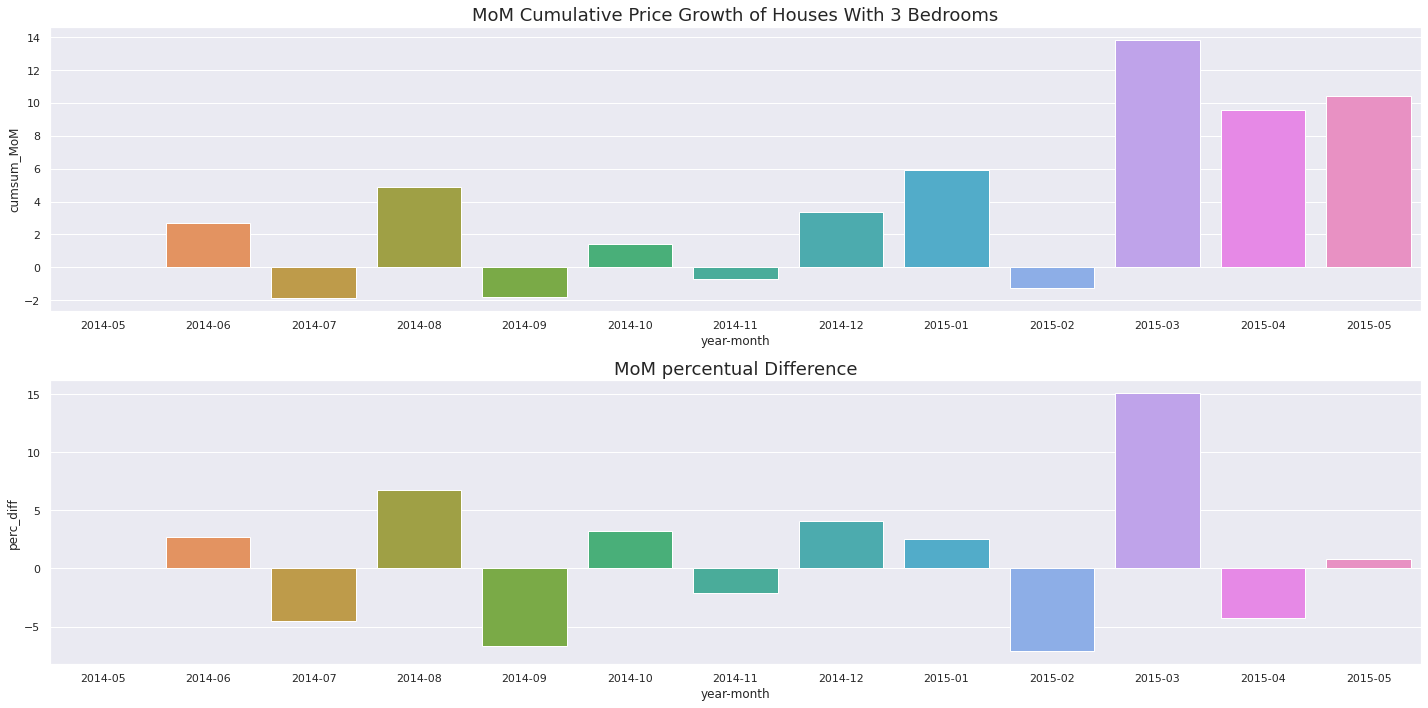

In [22]:
h5_1 = df[df['bathrooms'] == 3]
h5_2 = h5_1[['year-month', 'price/sqft_living']].groupby('year-month').mean().reset_index()
h5_2['perc_diff'] = (h5_2['price/sqft_living'].pct_change())*100
h5_2['cumsum_MoM'] = h5_2['perc_diff'].cumsum()

aux = list(np.sort(df['year-month'].unique()))
aux2 = (h5_2['perc_diff'].mean()).round(2)


plt.figure(figsize=(20,10))
sns.set_theme()

plt.subplot(2, 1, 1)
sns.barplot(x='year-month', y='cumsum_MoM', order=aux, data=h5_2).set_title('MoM Cumulative Price Growth of Houses With 3 Bedrooms', fontsize=18);

plt.subplot(2, 1, 2)
sns.barplot(x='year-month', y='perc_diff', order=aux, data=h5_2).set_title('MoM percentual Difference', fontsize=18);

plt.tight_layout()

print(f'The MoM average price growth of houses with 3 bathrooms is {aux2}%')

### H6 - Houses with better view (4) are 15% more expensive than other houses in average
**FALSE** Houses with better view costs in average 66.21% more than other houses

In [23]:
h6_1 = (df[df['view'] == 4]['price/sqft_living'].mean()).round(2)
h6_2 = (df[df['view'] != 4]['price/sqft_living'].mean()).round(2)
h6_3 = (((h6_1 - h6_2)/h6_2)*100).round(2)

print(f'Houses with better view (4) costs in average: R$ {h6_1}/sqft')
print(f'Houses with view classified as (1-4) costs in average: R$ {h6_2}/sqft')
print(f'Houses with better view are {h6_3}% more expensive in average')

Houses with better view (4) costs in average: R$ 434.81/sqft
Houses with view classified as (1-4) costs in average: R$ 261.6/sqft
Houses with better view are 66.21% more expensive in average


### H7 - Houses with better grade (11-13) are 25% more expensive than other houses in average
**FALSE** Houses with better grade costs in average 36.13% more than other houses

In [24]:
h7_1 = df[(df['grade']>= 11) & (df['grade']<=13)]['price/sqft_living']
h7_1 = (h7_1.mean()).round(2)
h7_2 = (df[df['grade']<11]['price/sqft_living'].mean()).round(2)
h7_3 = (((h7_1 - h7_2)/h7_2)*100).round(2)

print(f'Houses with better grade (11-13) costs in average: R$ {h7_1}/sqft')
print(f'Houses with grades lower than 11 costs in average: R$ {h7_2}/sqft')
print(f'Houses with better grade are {h7_3}% more expensive in average')

Houses with better grade (11-13) costs in average: R$ 356.6/sqft
Houses with grades lower than 11 costs in average: R$ 261.96/sqft
Houses with better grade are 36.13% more expensive in average


### H8 - Houses with 1 floor is bigger than those with 2 or 3 floors in average
**FALSE** Houses with 1 floor in average are smaller than houses with more floors

Houses with 1 floor have 1758.56 sqft in average
Houses with 2 floors have 2582.23 sqft in average
Houses with 3 floors have 1797.71 sqft in average


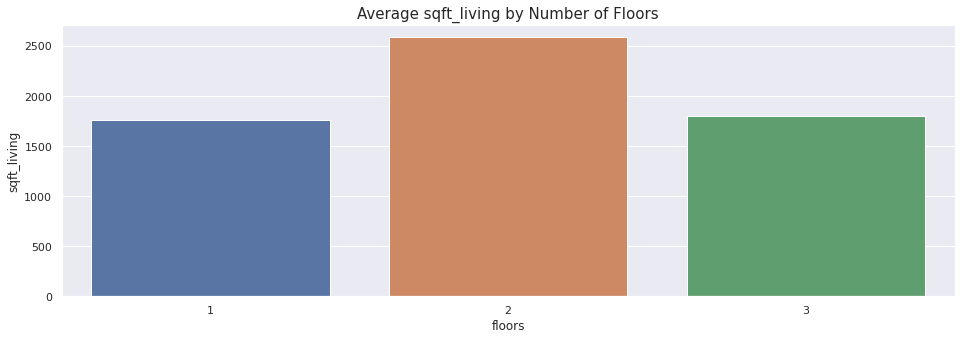

In [25]:
h8 = df[['floors', 'sqft_living']].groupby('floors').mean().reset_index()

plt.figure(figsize=(16, 5))
sns.barplot(x='floors', y='sqft_living', data=h8).set_title('Average sqft_living by Number of Floors', fontsize=15);

h8_1 = (df[df['floors'] == 1]['sqft_living'].mean()).round(2)
h8_2 = (df[df['floors'] == 2]['sqft_living'].mean()).round(2)
h8_3 = (df[df['floors'] == 3]['sqft_living'].mean()).round(2)

print(f'Houses with 1 floor have {h8_1} sqft in average')
print(f'Houses with 2 floors have {h8_2} sqft in average')
print(f'Houses with 3 floors have {h8_3} sqft in average')

### H9 - Houses that were renovated after 2005 has better condition in average
**FALSE** Houses that were renovated after 2005 has worst condition in average

In [26]:
h9_1 = df[df['yr_renovated']>=2005]['condition'].mean()
h9_2 = (df[df['yr_renovated']<2005]['condition'].mean()).round(4)

print(f'Houses that were renovated after 2005 have condition of {h9_1} in average')
print(f'Houses that were renovated before 2005 have condition of {h9_2} in average')

Houses that were renovated after 2005 have condition of 3.0375 in average
Houses that were renovated before 2005 have condition of 3.415 in average


### H10 - Houses with water front view has better grade
**TRUE** Houses with waterfront view has better grade in average

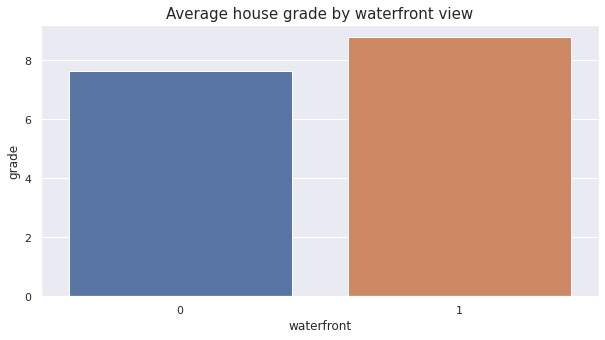

In [27]:
h10 = df[['waterfront', 'grade']].groupby('waterfront').mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x='waterfront', y='grade', data=h10).set_title('Average house grade by waterfront view', fontsize=15);

## 6.0. SELECTING HOUSES TO BUY
with lower price than median on the corresponding zipcode and with good condition (4-5)

In [28]:
df6 = df.copy()

In [29]:
houses_to_buy = df6[df6['flag']=='Buy']
houses_to_buy

id       date       price  bedrooms  bathrooms  sqft_living  \
17     9368700223 2015-02-02  310000.000         4          3         2010   
26     9368700341 2014-08-22  285000.000         3          2         2110   
28      185000118 2015-02-23  212000.000         4          2         1880   
36     3810000465 2014-05-20  243000.000         2          1         1770   
44     2144800215 2014-05-19  285000.000         4          1         2080   
...           ...        ...         ...       ...        ...          ...   
21578  2260300060 2015-04-10 2575000.000         5          3         4780   
21583  2525049246 2014-10-17 1550000.000         2          2         2950   
21592  3625049088 2014-07-02 2271150.000         4          3         4040   
21598  3025300225 2014-10-31 1450000.000         5          2         3090   
21607  2525049113 2014-07-25 1950000.000         4          3         4065   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
17         7426       1           0     0          5      7        1090   
26         6900       1           0     0          5      6        1220   
28         7500       1           0     0          5      6         980   
36         5522       1           0     0          4      7         960   
44        13629       1           0     0          4      7        1040   
...         ...     ...         ...   ...        ...    ...         ...   
21578     20440       1           0     0          4     10        3660   
21583     15593       1           0     0          4      8        1560   
21592     18916       1           0     0          4      9        4040   
21598     19865       1           0     0          4      9        3090   
21607     18713       2           0     0          4     10        4065   

       sqft_basement  yr_built  yr_renovated  zipcode    lat     long  \
17               920      1951             0    98178 47.504 -122.265   
26               890      1955             0    98178 47.504 -122.260   
28               900      1946             0    98178 47.495 -122.266   
36               810      1943             0    98178 47.497 -122.231   
44              1040      1955             0    98178 47.487 -122.232   
...              ...       ...           ...      ...    ...      ...   
21578           1120      1975             0    98039 47.624 -122.239   
21583           1390      1942          1986    98039 47.621 -122.236   
21592              0      1954             0    98039 47.615 -122.238   
21598              0      1953             0    98039 47.623 -122.235   
21607              0      1987             0    98039 47.621 -122.237   

       sqft_living15  sqft_lot15  price/sqft_living  zipcode_median_price  \
17              1470        7426            154.229               176.623   
26              1350        7683            135.071               176.623   
28              1670       14350            112.766               176.623   
36              1830        7378            137.288               176.623   
44              1780       14659            137.019               176.623   
...              ...         ...                ...                   ...   
21578           4660       20440            538.703               565.166   
21583           2060       19855            525.424               565.166   
21592           3000       18831            562.166               565.166   
21598           2970       19862            469.256               565.166   
21607           3070       18713            479.705               565.166   

      year-month flag  month_sale trimester  
17       2015-02  Buy           2        1T  
26       2014-08  Buy           8        3T  
28       2015-02  Buy           2        1T  
36       2014-05  Buy           5        2T  
44       2014-05  Buy           5        2T  
...          ...  ...         ...       ...  
21578    2015-04  Buy           4        2T  
21583  

## 7.0. SUGGESTING A PRICE TARGET

In [30]:
df7 = df6.copy()

- Se o preço do imóvel for maior que a mediana da região + sazonalidade (trimester) o Preço da Venda será igual ao preço da compra + 10%

- Se o preço do imóvel for menor que a mediana da região + sazonalidade (trimester) o Preço da Venda será igual ao preço da compra + 30%

In [31]:
# Calculating Median Price by zipcode and by Trimester for each zipcode
aux = df7[['trimester', 'zipcode', 'price/sqft_living']].groupby(['trimester', 'zipcode']).median().reset_index()

aux.columns = ['trimester', 'zipcode', 'price/sqft/Tri']

# Merging DataFrame
df7 = pd.merge(df7, aux, on=['zipcode', 'trimester'], how='inner')
df7 = df7.drop(['price/sqft/Tri_x', 'price/sqft/Tri_y', 'price/sqft/Tri_x', 'price/sqft/Tri_y'], axis=1)

KeyError: "['price/sqft/Tri_x' 'price/sqft/Tri_y' 'price/sqft/Tri_x'\n 'price/sqft/Tri_y'] not found in axis"

In [ ]:
# Labelling the profit percentage (10% or 30%)
df7['profit_perc'] = df7.apply(lambda x: '10%' if x['price/sqft_living'] > x['price/sqft/Tri'] else '30%', axis=1)

# Calculating the Final cost of houses
df7['price_target'] = df7.apply(lambda x: (x['price']) + (x['price']*0.1) if x['profit_perc'] == '10%' else
                                          (x['price']) + (x['price']*0.3), axis=1)

# Calculating nominal profit
df7['nominal_profit'] = df7['price_target'] - df7['price']


# MAIN INSIGHTS (5)

# BUSINESS RESULTS

## Assuming that House Rocket is buying houses

In [ ]:
# Selecting Houses with 'Buy' flag
aux = df7[df7['flag'] == 'Buy'].copy()

# Calculating the price_sale by the median price by zipcode
aux['price_sale'] = aux['zipcode_median_price'] * aux['sqft_living']

# Calculating the difference between the actual house price and the median price by zipcode
aux['save'] = aux['price_sale'] - aux['price']

# Total profit
total_profit = (aux['save'].sum()).round(2)

print(f'House Rocket could profit up to R$ {total_profit}')

Assuming that House Rocket buy all the houses with the flag 'Buy' and sell them by the mean price of the region, they could profit up to R$ 330,312,625

## Assuming that House Rocket is Selling houses

In [ ]:
total_profit = df7['nominal_profit'].sum()
print(f'If House Rocket sell all houses with the price_target, it would generate a total profit of R$ {total_profit}')

Assuming that House Rocket was to sell the houses of the dataset, they would generate a total profit of R$ 2,252,953,241.6

# CONCLUSION

In this project we created two scenarios:
- 1. House Rocket is interested in buying houses and they have a dataset of houses they kept track of to indentify the best opportunities;
- 2. House Rocket is selling all houses of the dataset and we estipulated a price target for all of them based on some conditions.

For the 1st scenario we identified houses with prices/sqft lower than the average of the region it is in and in good conditions suggesting to buy those houses. Than we created a list of those houses and suggested a new selling price calculated by the average of the price/sqft of the region.


Doing so House Rocket could profit up to R$ 330,312,625


For the 2nd scenario we suggested a selling price based on 2 conditions:
- If the original price/sqft was lower than the average of the region and by trimester they were acquired, than we added 30% on the original price
If the original price/sqft was higher than the average of the region and by trimester they were acquired, than we added 10% on the original price

If House Rocket were to sell all houses by the price_target we suggested, they would have a profit of R$ 2,252,953,241.6

# NEXT STEPS

In [38]:
dicionario = {'x':(10, 20)}
dicionario['x'][1]

20